# 0. Preparation

### 0.1. Load Libraries

In [1]:
# Environment Variables
import os
from dotenv import load_dotenv

# BigQuery Connection
from google.oauth2 import service_account
from google.cloud import bigquery

# Numpy & Pandas
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Statistics
import scipy.stats as stats
from scipy.stats import chi2_contingency
from statsmodels.stats import proportion

# Ignore Warning
import warnings
warnings.filterwarnings(action='ignore')

### 0.2. Environment Variables

In [2]:
load_dotenv()

BIGQUERY_CREDENTIALS_FPATH = os.getenv('BIGQUERY_CREDENTIALS_FPATH')
BIGQUERY_PROJECT_NAME = os.getenv('BIGQUERY_PROJECT_NAME')
BIGQUERY_DATASET_NAME = os.getenv('BIGQUERY_DATASET_NAME')
BIGQUERY_TABLE_NAME = 'events_*'
BIGQUERY_TABLE_ID = f'{BIGQUERY_PROJECT_NAME}.{BIGQUERY_DATASET_NAME}.{BIGQUERY_TABLE_NAME}'

EXPERIMENT_ID = os.getenv('EXPERIMENT_ID')
START_DATE = os.getenv('START_DATE')
END_DATE = os.getenv('END_DATE')

### 0.3. Connect to BigQuery

In [3]:
credentials = service_account.Credentials.from_service_account_file(BIGQUERY_CREDENTIALS_FPATH)

client = bigquery.Client(
    credentials = credentials,
    project = credentials.project_id
)

if client:
    print('BigQuery is Connected!')

BigQuery is Connected!


### 0.4. Experiment Info

In [4]:
CONFIDENCE_LEVEL = 0.95
ALPHA = 1 - CONFIDENCE_LEVEL

print(f'Confidence Level: {CONFIDENCE_LEVEL:.2f}')
print(f'Type 1 Error (alpha): {ALPHA:.2f}')

Confidence Level: 0.95
Type 1 Error (alpha): 0.05


# 1. Independence Test

### 1.1. Extract Raw Data

In [5]:
SQL = f"""
    WITH
    CTE_raw AS (
        SELECT
            DISTINCT
            user_pseudo_id,
            (SELECT value.string_value FROM UNNEST (event_params) WHERE key = 'variant_id') AS variant_id,
            geo.country,
            device.category AS device_type
        FROM
            `{BIGQUERY_TABLE_ID}`
        WHERE
            _table_suffix BETWEEN FORMAT_DATE('%Y%m%d', '{START_DATE}') AND FORMAT_DATE('%Y%m%d', '{END_DATE}')
            AND event_name = 'experiment_impression'
            AND (SELECT value.string_value FROM UNNEST (event_params) WHERE key = 'experiment_id') = '{EXPERIMENT_ID}'
            AND user_pseudo_ID IS NOT NULL
    )
    SELECT
        user_pseudo_id,
        CASE
            WHEN ENDS_WITH(variant_id, '.0') THEN 'A'
            WHEN ENDS_WITH(variant_id, '.1') THEN 'B'
        END AS test_group,
        CASE
            WHEN country IN ('South Korea', 'United States') THEN country
            ELSE 'Others'
        END AS country,
        CASE
            WHEN device_type IN ('desktop', 'mobile', 'tablet') THEN device_type
            ELSE 'others'
        END AS device_type
    FROM
        CTE_raw
"""

results = client.query(SQL)
independence_df = results.to_dataframe()
independence_df.drop(columns=['user_pseudo_id']).head()

,test_group,country,device_type
0,B,Others,mobile
1,B,Others,mobile
2,A,South Korea,desktop
3,B,South Korea,mobile
4,B,South Korea,mobile


### 1.2. Independence Test

* (1) Country

In [6]:
countries = independence_df[['test_group', 'country']]
contingency_table = pd.crosstab(
    countries['test_group'],
    countries['country']
)

chi_value, p_value, df, expected = chi2_contingency(contingency_table)
print(f'chi-squared: {chi_value:.4f}')
print(f'p-value: {p_value:.4f}')

if p_value < ALPHA:
  print('Countries and Test Groups are Related.')
else:
  print('Countries and Test Groups are Independent.')

chi-squared: 1.5749
p-value: 0.4550
Countries and Test Groups are Independent.


* (2) Device Type

In [7]:
device_types = independence_df[['test_group', 'device_type']]
contingency_table = pd.crosstab(
    device_types['test_group'],
    device_types['device_type']
)

chi_value, p_value, df, expected = chi2_contingency(contingency_table)
print(f'chi-squared: {chi_value:.4f}')
print(f'p-value: {p_value:.4f}')

if p_value < ALPHA:
  print('Countries and Test Groups are Related.')
else:
  print('Countries and Test Groups are Independent.')

chi-squared: 4.7465
p-value: 0.0932
Countries and Test Groups are Independent.


# 2. Extract Raw Data

### 2.1. Purchase CVR, Add-to-cart CVR, Begin-checkout CVR

In [8]:
EVENT_NAMES = ['purchase', 'add_to_cart', 'begin_checkout']

for EVENT_NAME in EVENT_NAMES:
  SQL = f"""
        WITH
        CTE_raw AS (
            SELECT
                user_pseudo_id,
                event_timestamp,
                event_name,
                (SELECT value.string_value FROM UNNEST (event_params) WHERE key = 'experiment_id') AS experiment_id,
                (SELECT value.string_value FROM UNNEST (event_params) WHERE key = 'variant_id') AS variant_id
            FROM
                `{BIGQUERY_TABLE_ID}`
            WHERE
                _table_suffix BETWEEN FORMAT_DATE('%Y%m%d', '{START_DATE}') AND FORMAT_DATE('%Y%m%d', '{END_DATE}')
                AND event_name IN ('experiment_impression', '{EVENT_NAME}')
                AND user_pseudo_ID IS NOT NULL
                AND event_timestamp IS NOT NULL
        ),
        CTE_users_assigned AS (
            SELECT
                user_pseudo_id,
                CASE
                    WHEN ENDS_WITH(variant_id, '.0') THEN 'A'
                    WHEN ENDS_WITH(variant_id, '.1') THEN 'B'
                END AS test_group,
                MIN(event_timestamp) AS assigned_timestamp
            FROM
                CTE_raw
            WHERE
                event_name = 'experiment_impression'
                AND experiment_id = '{EXPERIMENT_ID}'
                AND variant_id IS NOT NULL
            GROUP BY
                1, 2
        ),
        CTE_users_converted AS (
            SELECT
                user_pseudo_id,
                event_timestamp AS converted_timestamp
            FROM
                CTE_raw
            WHERE
                event_name = '{EVENT_NAME}'
        ),
        CTE_users_assigned_converted AS (
            SELECT
                DISTINCT
                A.user_pseudo_id
            FROM
                CTE_users_converted C
            LEFT JOIN
                CTE_users_assigned A
                ON C.user_pseudo_id = A.user_pseudo_id
                AND C.converted_timestamp >= A.assigned_timestamp
        )
        SELECT
            A.user_pseudo_id,
            A.test_group,
            CASE
                WHEN AC.user_pseudo_id IS NOT NULL THEN 1
                ELSE 0
            END AS converted
        FROM
            CTE_users_assigned A
        LEFT JOIN
            CTE_users_assigned_converted AC
            ON A.user_pseudo_id = AC.user_pseudo_id
  """

  results = client.query(SQL)
  if EVENT_NAME == 'purchase':
    purchase_cvr_df = results.to_dataframe()
  elif EVENT_NAME == 'add_to_cart':
    addtocart_cvr_df = results.to_dataframe()
  elif EVENT_NAME == 'begin_checkout':
    begincheckout_cvr_df = results.to_dataframe()

In [9]:
purchase_cvr_df.drop(columns=['user_pseudo_id']).head()

,test_group,converted
0,A,1
1,B,0
2,A,1
3,B,0
4,A,0


In [10]:
addtocart_cvr_df.drop(columns=['user_pseudo_id']).head()

,test_group,converted
0,B,0
1,A,0
2,B,0
3,B,0
4,B,0


In [11]:
begincheckout_cvr_df.drop(columns=['user_pseudo_id']).head()

,test_group,converted
0,B,0
1,B,0
2,A,1
3,B,0
4,A,0


### 2.2. Other Platforms CVR

In [12]:
SQL = f"""
    WITH
    CTE_raw AS (
        SELECT
            user_pseudo_id,
            event_timestamp,
            event_name,
            REPLACE(
                REGEXP_REPLACE(
                    REGEXP_REPLACE(
                        LOWER((SELECT value.string_value FROM UNNEST (event_params) WHERE key = 'page_location')),
                        r'(\?.*)$', ''
                    ),
                    r'/$', ''
                ),
                'https://', ''
            ) AS page_location,
            REPLACE(
                REGEXP_REPLACE(
                    REGEXP_REPLACE(
                        LOWER((SELECT value.string_value FROM UNNEST (event_params) WHERE key = 'link_url')),
                        r'(\?.*)$', ''
                    ),
                    r'/$', ''
                ),
                'https://', ''
            ) AS link_url,
            (SELECT value.string_value FROM UNNEST (event_params) WHERE key = 'experiment_id') AS experiment_id,
            (SELECT value.string_value FROM UNNEST (event_params) WHERE key = 'variant_id') AS variant_id
        FROM
            `{BIGQUERY_TABLE_ID}`
        WHERE
            _table_suffix BETWEEN FORMAT_DATE('%Y%m%d', '{START_DATE}') AND FORMAT_DATE('%Y%m%d', '{END_DATE}')
            AND event_name IN ('experiment_impression', 'click')
            AND user_pseudo_ID IS NOT NULL
            AND event_timestamp IS NOT NULL
    ),
    CTE_users_assigned AS (
        SELECT
            user_pseudo_id,
            CASE
                WHEN ENDS_WITH(variant_id, '.0') THEN 'A'
                WHEN ENDS_WITH(variant_id, '.1') THEN 'B'
            END AS test_group,
            MIN(event_timestamp) AS assigned_timestamp
        FROM
            CTE_raw
        WHERE
            event_name = 'experiment_impression'
            AND experiment_id = '{EXPERIMENT_ID}'
            AND variant_id IS NOT NULL
        GROUP BY
            1, 2
    ),
    CTE_users_converted AS (
        SELECT
            user_pseudo_id,
            event_timestamp AS converted_timestamp
        FROM
            CTE_raw
        WHERE
            event_name = 'click'
            AND page_location LIKE '%/shoplist%'
            AND (
            link_url LIKE '%amazon%'
            OR link_url LIKE '%smartstore.naver%'
            OR link_url LIKE '%auction%'
            OR link_url LIKE '%11st%'
            OR link_url LIKE '%gmarket%'
            )
    ),
    CTE_users_assigned_converted AS (
        SELECT
            DISTINCT
            A.user_pseudo_id
        FROM
            CTE_users_converted C
        LEFT JOIN
            CTE_users_assigned A
            ON C.user_pseudo_id = A.user_pseudo_id
            AND C.converted_timestamp >= A.assigned_timestamp
    )
    SELECT
        A.user_pseudo_id,
        A.test_group,
        CASE
            WHEN AC.user_pseudo_id IS NOT NULL THEN 1
            ELSE 0
        END AS converted
    FROM
        CTE_users_assigned A
    LEFT JOIN
        CTE_users_assigned_converted AC
        ON A.user_pseudo_id = AC.user_pseudo_id
"""

results = client.query(SQL)
otherplatforms_cvr_df = results.to_dataframe()
otherplatforms_cvr_df.drop(columns=['user_pseudo_id']).head()

,test_group,converted
0,B,0
1,B,0
2,B,0
3,A,0
4,A,0


### 2.3. ARPU

In [13]:
SQL = f"""
      WITH
      CTE_raw AS (
          SELECT
              user_pseudo_id,
              event_timestamp,
              event_name,
              ecommerce.purchase_revenue_in_usd AS revenue,
              (SELECT value.string_value FROM UNNEST (event_params) WHERE key = 'experiment_id') AS experiment_id,
              (SELECT value.string_value FROM UNNEST (event_params) WHERE key = 'variant_id') AS variant_id
          FROM
              `{BIGQUERY_TABLE_ID}`
          WHERE
              _table_suffix BETWEEN FORMAT_DATE('%Y%m%d', '{START_DATE}') AND FORMAT_DATE('%Y%m%d', '{END_DATE}')
              AND event_name IN ('experiment_impression', 'purchase')
              AND user_pseudo_ID IS NOT NULL
              AND event_timestamp IS NOT NULL
      ),
      CTE_users_assigned AS (
          SELECT
              user_pseudo_id,
              CASE
                  WHEN ENDS_WITH(variant_id, '.0') THEN 'A'
                  WHEN ENDS_WITH(variant_id, '.1') THEN 'B'
              END AS test_group,
              MIN(event_timestamp) AS assigned_timestamp
          FROM
              CTE_raw
          WHERE
              event_name = 'experiment_impression'
              AND experiment_id = '{EXPERIMENT_ID}'
              AND variant_id IS NOT NULL
          GROUP BY
              1, 2
      ),
      CTE_users_revenue AS (
          SELECT
              user_pseudo_id,
              event_timestamp AS purchased_timestamp,
              revenue
          FROM
              CTE_raw
          WHERE
              event_name = 'purchase'
      ),
      CTE_users_assigned_revenue AS (
          SELECT
              A.user_pseudo_id,
              SUM(R.revenue) AS revenue
          FROM
              CTE_users_revenue R
          LEFT JOIN
              CTE_users_assigned A
              ON R.user_pseudo_id = A.user_pseudo_id
              AND R.purchased_timestamp > A.assigned_timestamp
          GROUP BY
              1
      )
      SELECT
          A.user_pseudo_id,
          A.test_group,
          COALESCE(AR.revenue, 0) AS revenue
      FROM
          CTE_users_assigned A
      LEFT JOIN
          CTE_users_assigned_revenue AR
          ON A.user_pseudo_id = AR.user_pseudo_id
"""

results = client.query(SQL)
arpu_df = results.to_dataframe()
arpu_df.drop(columns=['user_pseudo_id']).head()

,test_group,revenue
0,B,0.0
1,B,0.0
2,B,0.0
3,B,0.0
4,B,0.0


# 3. Analysis

### 3.1. Key Metrics (1) Purchase CVR

* (1) Assumption

In [14]:
na = purchase_cvr_df.groupby('test_group')['user_pseudo_id'].count()['A']
nb = purchase_cvr_df.groupby('test_group')['user_pseudo_id'].count()['B']

xa = purchase_cvr_df.groupby('test_group')['converted'].sum()['A']
xb = purchase_cvr_df.groupby('test_group')['converted'].sum()['B']

pa = xa / na
pb = xb / nb

if (na * pa < 5) or (na * (1 - pa) < 5) or (nb * pb < 5) or (nb * (1 - pb) < 5):
    print('Assumption Not Satisfied!')
else:
    print('Good to go!')

Good to go!


* (2) Two-proportion z-test

In [15]:
z_result = proportion.proportions_ztest(
    count = [xa, xb],
    nobs = [na, nb],
    alternative = 'smaller'
)
z, p_value_purchase_cvr = z_result

print(f'Analysis Results (Confidence Level: {CONFIDENCE_LEVEL * 100:.0f}%)')

if p_value_purchase_cvr < ALPHA:
  print('- Null hypothesis can be rejected. (A < B)')
else:
  print('- Null hypothesis can NOT be rejected. (A >= B)')

print('===============================================')

print(f'p-value = {p_value_purchase_cvr:.4f}')
print('- Purchase CVR (A):', 'xx %')
print('- Purchase CVR (B):', 'xx %')

Analysis Results (Confidence Level: 95%)
- Null hypothesis can NOT be rejected. (A >= B)
p-value = 0.0984
- Purchase CVR (A): xx %
- Purchase CVR (B): xx %


### 3.2. Key Metrics (2) ARPU

* (1) Assumption

In [16]:
na = arpu_df.groupby('test_group')['user_pseudo_id'].count()['A']
nb = arpu_df.groupby('test_group')['user_pseudo_id'].count()['B']

if na + nb < 30:
    print('Assumption Not Satisfied!')
else:
    print('Good to go!')

Good to go!


* (2) Equal-variance Test: Bartlett's Test

In [17]:
stat, p_value_bartlett = stats.bartlett(
    arpu_df[arpu_df['test_group'] == 'A']['revenue'].reset_index(drop=True),
    arpu_df[arpu_df['test_group'] == 'B']['revenue'].reset_index(drop=True)
)

print(f'Equal-variance Test Results (Confidence Level: {CONFIDENCE_LEVEL * 100:.0f}%)')

if p_value_bartlett < ALPHA:
  print('- Variances are NOT equal!')
  EQUAL_VAR = False
else:
  print('- Variances are equal!')
  EQUAL_VAR = True

print('===============================================')

print(f'p-value = {p_value_bartlett:.4f}')

Equal-variance Test Results (Confidence Level: 95%)
- Variances are equal!
p-value = 0.1231


* (3) Two-sample t-test

In [18]:
t_result = stats.ttest_ind(
    arpu_df[arpu_df['test_group'] == 'A']['revenue'].reset_index(drop=True),
    arpu_df[arpu_df['test_group'] == 'B']['revenue'].reset_index(drop=True),
    equal_var = EQUAL_VAR,
    alternative = 'less'
)
t, p_value_arpu = t_result

print(f'Analysis Results (Confidence Level: {CONFIDENCE_LEVEL * 100:.0f}%)')

if p_value_arpu < ALPHA:
  print('- Null hypothesis can be rejected. (A < B)')
else:
  print('- Null hypothesis can NOT be rejected. (A >= B)')

print('===============================================')

mean_a = arpu_df.groupby('test_group')['revenue'].mean()[0]
mean_b = arpu_df.groupby('test_group')['revenue'].mean()[1]

print(f'p-value = {p_value_arpu:.4f}')
print('- ARPU (A):', 'US$ xx')
print('- ARPU (B):', 'US$ xx')

Analysis Results (Confidence Level: 95%)
- Null hypothesis can NOT be rejected. (A >= B)
p-value = 0.2284
- ARPU (A): US$ xx
- ARPU (B): US$ xx


### 3.3. Supplementary Metrics (1) Add-to-cart CVR

* (1) Assumption

In [19]:
na = addtocart_cvr_df.groupby('test_group')['user_pseudo_id'].count()['A']
nb = addtocart_cvr_df.groupby('test_group')['user_pseudo_id'].count()['B']

xa = addtocart_cvr_df.groupby('test_group')['converted'].sum()['A']
xb = addtocart_cvr_df.groupby('test_group')['converted'].sum()['B']

pa = xa / na
pb = xb / nb

if (na * pa < 5) or (na * (1 - pa) < 5) or (nb * pb < 5) or (nb * (1 - pb) < 5):
    print('Assumption Not Satisfied!')
else:
    print('Good to go!')

Good to go!


* (2) Two-proportion z-test

In [20]:
z_result = proportion.proportions_ztest(
    count = [xa, xb],
    nobs = [na, nb],
    alternative = 'smaller'
)
z, p_value_addtocart_cvr = z_result

print(f'Analysis Results (Confidence Level: {CONFIDENCE_LEVEL * 100:.0f}%)')

if p_value_addtocart_cvr < ALPHA:
  print('- Null hypothesis can be rejected. (A < B)')
else:
  print('- Null hypothesis can NOT be rejected. (A >= B)')

print('===============================================')

print(f'p-value = {p_value_addtocart_cvr:.4f}')
print('- Add to Cart CVR (A):', 'xx %')
print('- Add to Cart CVR (B):', 'xx %')

Analysis Results (Confidence Level: 95%)
- Null hypothesis can be rejected. (A < B)
p-value = 0.0438
- Add to Cart CVR (A): xx %
- Add to Cart CVR (B): xx %


### 3.4. Supplementary Metrics (2) Begin-checkout CVR

* (1) Assumption

In [21]:
na = begincheckout_cvr_df.groupby('test_group')['user_pseudo_id'].count()['A']
nb = begincheckout_cvr_df.groupby('test_group')['user_pseudo_id'].count()['B']

xa = begincheckout_cvr_df.groupby('test_group')['converted'].sum()['A']
xb = begincheckout_cvr_df.groupby('test_group')['converted'].sum()['B']

pa = xa / na
pb = xb / nb

if (na * pa < 5) or (na * (1 - pa) < 5) or (nb * pb < 5) or (nb * (1 - pb) < 5):
    print('Assumption Not Satisfied!')
else:
    print('Good to go!')

Good to go!


* (2) Two-proportion z-test

In [22]:
z_result = proportion.proportions_ztest(
    count = [xa, xb],
    nobs = [na, nb],
    alternative = 'smaller'
)
z, p_value_begincheckout_cvr = z_result

print(f'Analysis Results (Confidence Level: {CONFIDENCE_LEVEL * 100:.0f}%)')

if p_value_begincheckout_cvr < ALPHA:
  print('- Null hypothesis can be rejected. (A < B)')
else:
  print('- Null hypothesis can NOT be rejected. (A >= B)')

print('===============================================')

print(f'p-value = {p_value_begincheckout_cvr:.4f}')
print('- Begin Checkout CVR (A):', 'xx %')
print('- Begin Checkout CVR (B):', 'xx %')

Analysis Results (Confidence Level: 95%)
- Null hypothesis can NOT be rejected. (A >= B)
p-value = 0.1194
- Begin Checkout CVR (A): xx %
- Begin Checkout CVR (B): xx %


### 3.5. Guardrail Metrics (1) Other Platforms CVR

* (1) Assumption

In [23]:
na = otherplatforms_cvr_df.groupby('test_group')['user_pseudo_id'].count()['A']
nb = otherplatforms_cvr_df.groupby('test_group')['user_pseudo_id'].count()['B']

xa = otherplatforms_cvr_df.groupby('test_group')['converted'].sum()['A']
xb = otherplatforms_cvr_df.groupby('test_group')['converted'].sum()['B']

pa = xa / na
pb = xb / nb

if (na * pa < 5) or (na * (1 - pa) < 5) or (nb * pb < 5) or (nb * (1 - pb) < 5):
    print('Assumption Not Satisfied!')
else:
    print('Good to go!')

Good to go!


* (2) Two-proportion z-test

In [24]:
z_result = proportion.proportions_ztest(
    count = [xa, xb],
    nobs = [na, nb],
    alternative = 'smaller'
)
z, p_value_otherplatforms_cvr = z_result

print(f'Analysis Results (Confidence Level: {CONFIDENCE_LEVEL * 100:.0f}%)')

if p_value_otherplatforms_cvr < ALPHA:
  print('- Null hypothesis can be rejected. (A < B)')
else:
  print('- Null hypothesis can NOT be rejected. (A >= B)')

print('===============================================')

print(f'p-value = {p_value_otherplatforms_cvr:.4f}')
print('- Other Platforms CVR (A):', 'xx %')
print('- Other Platforms CVR (B):', 'xx %')

Analysis Results (Confidence Level: 95%)
- Null hypothesis can NOT be rejected. (A >= B)
p-value = 0.5758
- Other Platforms CVR (A): xx %
- Other Platforms CVR (B): xx %


# 4. Summary

### 3.1. Key Metrics (1) Purchase CVR

In [25]:
metrics = [
    'Purchase CVR',
    'ARPU',
    'Add to Cart CVR',
    'Begin Checkout CVR',
    'Other Platforms CVR'
]
p_values = [
    p_value_purchase_cvr,
    p_value_arpu,
    p_value_addtocart_cvr,
    p_value_begincheckout_cvr,
    p_value_otherplatforms_cvr
]

results_df = pd.DataFrame({
    'metric': metrics,
    'p_value': p_values
})
results_df['reject_null'] = results_df['p_value'] < ALPHA

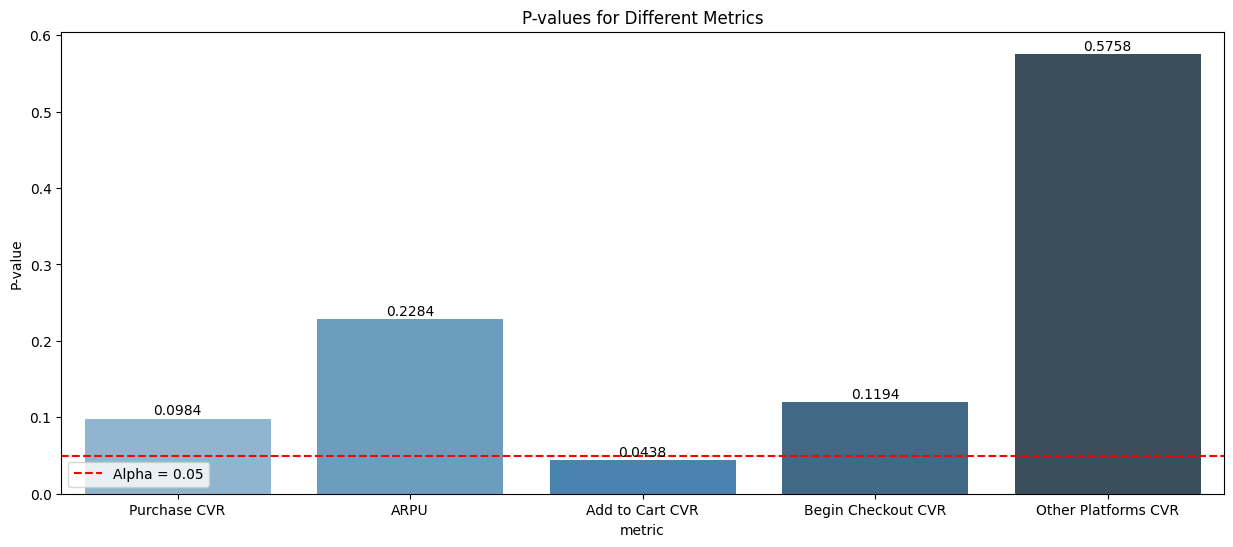

In [26]:
plt.figure(figsize=(15, 6))
sns.barplot(x='metric', y='p_value', data=results_df, palette='Blues_d')

plt.axhline(y=ALPHA, color='red', linestyle='--', label=f'Alpha = {ALPHA:.2f}')
plt.title('P-values for Different Metrics')
plt.ylabel('P-value')
plt.legend(loc='lower left')

for index, row in results_df.iterrows():
    plt.text(index, row.p_value + 0.005, f'{row.p_value:.4f}', color='black', ha='center')